# Plot figures
To plot the final figures.
This script takes in the model summary files and plots results.

In [1]:
import numpy as np
from scipy.spatial.distance import cdist # For calculating QPSK decoding
import dill
from itertools import product, cycle

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

Utility function to extract data from figures -- work in progress

In [2]:
# The one who steals the data
def robinhood(fig, filename, col_dtype=[float, float], col_fmt=None):
    assert (len(fig.axes) < 2), "More than one axis not supported"
    ax = fig.axes[0]
    
    header = []
    fmt = []
    
    # Don't modify the argument here, it will get updated for all the following calls
    if not col_fmt:
        _col_fmt = [ "%d" if d == int else "%.5f" for d in col_dtype ]
    else:
        _col_fmt = col_fmt.copy()
    
    n_lines = len(ax.lines)
    x_data = ax.lines[0].get_xdata()
    
    data = np.zeros((x_data.shape[0], 2 * n_lines))
    
    for(i, line) in enumerate(ax.lines):
        data[:, 2*i] = line.get_xdata()
        data[:, 2*i+1] = line.get_ydata()
        
        header += ["x_" + line.get_label(), "y_" + line.get_label()]
        fmt += _col_fmt
            
    if filename is not None:
        with open(filename, 'w') as f:
            f.write(",".join(header) + "\n")
            np.savetxt(f, data, delimiter=",", fmt=",".join(fmt))

### Configuration of experiment

In [3]:
blkSize     = 8
chDim       = 4

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim

GSNR_range_dB = np.arange( 0.0, 21.0, 2.0 )

one_hot_code = np.eye(inVecDim)

enable_robinhood = False

### Traditional Methods
Load the constellation data from prespecified files and find BLER.

In [4]:
results_traditional = {}

In [5]:
qam_map = np.genfromtxt("./../AWGN/sphere_data/{:03d}x{:03d}_qam.csv".format(inVecDim,encDim))
qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

noisePower = qam_sym_pow * 10.0**(-GSNR_range_dB/10.0)
# n0_per_comp = noisePower/(2*chDim)

qam_d_min = np.unique(cdist(qam_map,qam_map))[1]
print("d_min:", qam_d_min )

qam_en = qam_sym_pow / (qam_d_min**2)
print("En:", qam_en)

QAM Avg. Tx Power: 8.0
d_min: 2.0
En: 2.0


In [6]:
Cg = 1.78
gamma = 1.0 / np.sqrt(2*Cg) * np.sqrt(noisePower)
gamma_per_comp = gamma / np.sqrt(2*chDim)

err = []
for n0 in gamma_per_comp:
    thisErr = 0
    thisCount = 0
    while thisErr < 500 and thisCount < 1e6:
        txSym = np.random.randint(inVecDim, size=1000)
        txTest = qam_map[txSym]
        rxTest = txTest + n0*np.random.standard_cauchy(size=txTest.shape)
        rxDecode = cdist(rxTest, qam_map)
        rxSym = np.argmin(rxDecode,axis=1)
        thisErr += np.sum(rxSym!=txSym)
        thisCount += 1000
#     print(n0, thisCount)
    err.append(thisErr/thisCount)
blkErr = np.array(err)

results_traditional["QAM"] = {
    "en": qam_en,
    "dmin": qam_d_min,
    "sym_pow": qam_sym_pow,
    "bler": np.array(err)
}

In [7]:
agrell_map = np.genfromtxt("./../AWGN/sphere_data/{:03d}x{:03d}_agrell.csv".format(inVecDim,encDim))
agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "QAM Avg. Tx Power:", agrell_sym_pow )

noisePower = agrell_sym_pow * 10.0**(-GSNR_range_dB/10.0)
# n0_per_comp = noisePower/(2*chDim)

agrell_d_min = np.unique(cdist(agrell_map,agrell_map))[1]
print("d_min:", agrell_d_min )

agrell_en = agrell_sym_pow / (agrell_d_min**2)
print("En:", agrell_en)

QAM Avg. Tx Power: 137610.0
d_min: 362.03867196751236
En: 1.0498809814453123


In [8]:
Cg = 1.78
gamma = 1.0 / np.sqrt(2*Cg) * np.sqrt(noisePower)
gamma_per_comp = gamma / np.sqrt(2*chDim)

err = []
for n0 in gamma_per_comp:
    thisErr = 0
    thisCount = 0
    while thisErr < 500 and thisCount < 1e6:
        txSym = np.random.randint(inVecDim, size=1000)
        txTest = agrell_map[txSym]
        rxTest = txTest + n0*np.random.standard_cauchy(size=txTest.shape)
        rxDecode = cdist(rxTest, agrell_map)
        rxSym = np.argmin(rxDecode,axis=1)
        thisErr += np.sum(rxSym!=txSym)
        thisCount += 1000
    err.append(thisErr/thisCount)
blkErr = np.array(err)

results_traditional["Agrell"] = {
    "en": agrell_en,
    "d_min": agrell_d_min,
    "sym_pow": agrell_sym_pow,
    "bler": np.array(err)
}

### Deep Learning models
Paths to each model summaries along with the label for legend

In [9]:
model_summary = {}
results = {}

if blkSize==8 and chDim==4:
    model_summary = { 
        "ae": "./models/08x04/Oshea/cau_oshea_64_32_16_06dB_summary.dil",
#         "ae_10dB": "./models/08x04/Oshea/cau_oshea_64_32_16_10dB_summary.dil",
#         "ae_20dB": "./models/08x04/Oshea/cau_oshea_64_32_16_20dB_summary.dil",
#         "vae_awgn": "./models/08x04/AWGN/cau_awgn_64_32_16_n020_sigma0500_summary.dil",
#         "vae_rbf": "./models/08x04/RBF/cau_rbf_64_32_16_n020_sigma0500_summary.dil",
#         "vae_cau_0300": "./models/08x04/CAU/cau_cau_64_32_16_n020_sigma0300_summary.dil",
        "vae_cau": "./models/08x04/CAU/cau_cau_64_32_16_n020_sigma0500_summary.dil"
    }
elif blkSize==4 and chDim==2:
    model_summary = {
        "ae": "./models/04x02/Oshea/cau_oshea_64_32_16_05dB_summary.dil",
#         "ae_10dB": "./models/04x02/Oshea/cau_oshea_64_32_16_10dB_summary.dil", # BLER evo error
#         "ae_20dB": "./models/04x02/Oshea/cau_oshea_64_32_16_20dB_summary.dil",
#         "vae_awgn": "./models/04x02/AWGN/cau_awgn_64_32_16_n020_sigma0500_summary.dil",
#         "vae_rbf": "./models/04x02/RBF/cau_rbf_64_32_16_n020_sigma0500_summary.dil",
        "vae_cau": "./models/04x02/CAU/cau_cau_64_32_16_n020_sigma0500_summary.dil"
    }
elif blkSize==2 and chDim==1:
    model_summary = {
        "ae": "./models/02x01/Oshea/cau_oshea_64_32_16_06dB_summary.dil",
#         "ae_10dB": "./models/02x01/Oshea/cau_oshea_64_32_16_10dB_summary.dil", # BLER evo err
#         "vae_awgn": "./models/02x01/AWGN/cau_awgn_64_32_16_n020_sigma0300_summary.dil",
#         "vae_rbf": "./models/02x01/RBF/cau_rbf_64_32_16_n020_sigma0300_summary.dil",
        "vae_cau": "./models/02x01/CAU/cau_cau_64_32_16_n020_sigma0300_summary.dil"
    }
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

In [10]:
import os.path
for (model_exp, summary_file) in model_summary.items():
    log_msg = "{:40s}    {:70s}".format(model_exp,summary_file)
    if os.path.isfile(summary_file):
        log_msg += "EXISTS"
    else:
        log_msg += "NOT FOUND"
    print(log_msg)

ae                                          ./models/08x04/Oshea/cau_oshea_64_32_16_06dB_summary.dil              EXISTS
vae_cau                                     ./models/08x04/CAU/cau_cau_64_32_16_n020_sigma0500_summary.dil        EXISTS


Load the results from summary files

In [11]:
results = {}
for (label, summary_file) in model_summary.items():
    with open(summary_file, "rb") as file:
        results[label] = dill.load(file)

### Plot evolution of packing densities

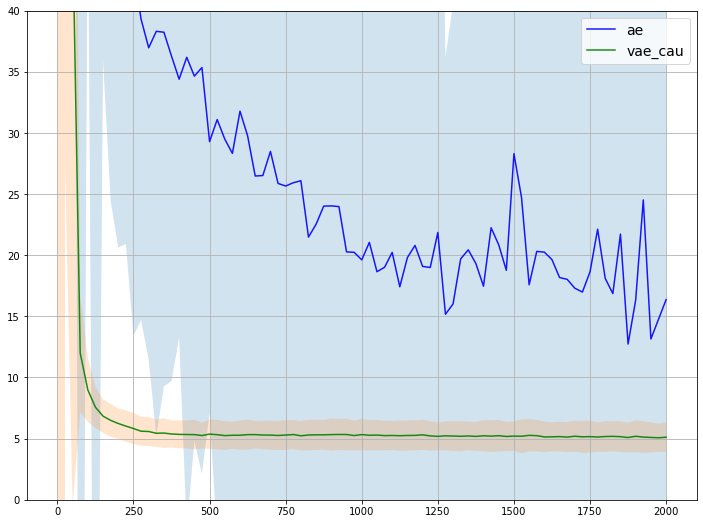

In [12]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(2*4*1.5, 2*3*1.5))
data = {}

for (label, result_dict) in results.items():
    epochs = result_dict[list(result_dict.keys())[0]]["packing_density_epochs"]
    d = []
    clr = next(colors)
    for (modelid, log) in result_dict.items():
#         plt.semilogy(log["packing_density_epochs"],
#                  log["packing_density_en"], color=clr, alpha=0.1)
        d.append(log["packing_density_en"])
    d_mean = np.mean(d, axis=0)
    d_std = np.std(d, axis=0)
    plt.fill_between(result_dict[list(result_dict.keys())[0]]["packing_density_epochs"],
                    d_mean+d_std, d_mean-d_std, alpha=0.20)
    plt.plot(result_dict[list(result_dict.keys())[0]]["packing_density_epochs"],
                 d_mean, color=clr, alpha=0.9, label=label)
    
    # hack for robinhood to pickup shaded area
    plt.plot(result_dict[list(result_dict.keys())[0]]["packing_density_epochs"], d_mean + d_std, 
             label= label + "_upper" if enable_robinhood else None,
             color=clr, alpha=0.00)
    plt.plot(result_dict[list(result_dict.keys())[0]]["packing_density_epochs"], d_mean - d_std, 
             label= label + "_lower" if enable_robinhood else None,
             color=clr, alpha=0.00)

# plt.plot(epochs, len(epochs)*[results_traditional["QAM"]["en"]], linewidth=3, label="QAM", color=next(colors), linestyle="-.")
# plt.plot(epochs, len(epochs)*[results_traditional["Agrell"]["en"]], linewidth=3, label="Agrell", color=next(colors), linestyle="-.")
    
if blkSize==2 and chDim==1:
    plt.ylim([0.25, 1.25])
elif blkSize==4 and chDim==2:
    plt.ylim([1.25, 2.20])
elif blkSize==8 and chDim==4:
    plt.ylim([0, 40])
# plt.xlim([0, 3000])
plt.legend(loc='upper right', prop={'size':14})
plt.grid()

# robinhood(fig, "output_awgn_en_evo_{:02d}x{:02d}.csv".format(blkSize,chDim), col_dtype=[int, float])

### Plot Packing Density

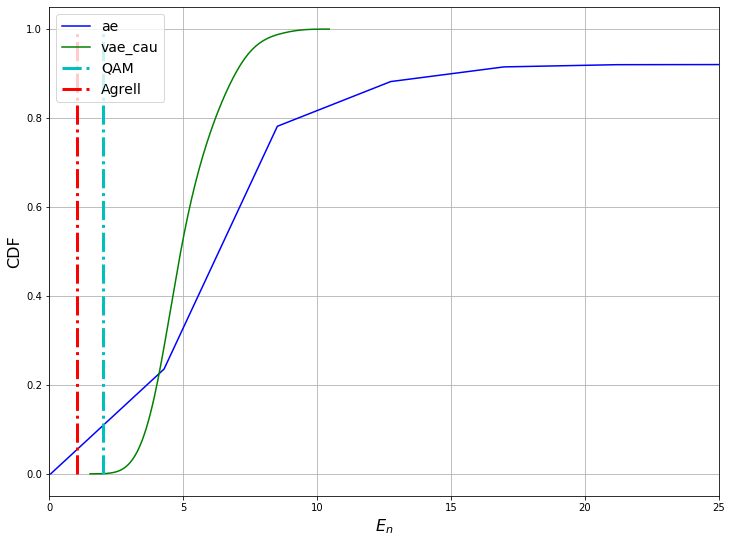

In [13]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(2*4*1.5,2*3*1.5))

for (label, result) in results.items():
    clr = next(colors)
    en = [ log["packing_density_en"][-1] for log in result.values() ]
    sns.distplot([log["packing_density_en"][-1] for log in result.values()], 
                 label=label, color=clr,
                 bins=100, rug=False, 
                 
                 kde=True, 
                 kde_kws=dict(cumulative=True, 
                              linestyle=":" if "Oshea" in label or "[1]" in label else "-"),
                 
                 hist=False,
                 hist_kws=dict(cumulative=True, 
                               density=True, 
                               histtype="step", 
                               linestyle=":" if "Oshea" in label or "[1]" in label else "-",
                               linewidth=2,
                               color=clr, alpha=1.0))
    
#     sns.distplot([log["packing_density_en"][-1] for log in result.values()], 
#                  label=label, color=clr,
#                  bins=100, rug=False, 
                 
#                  kde=False, 
#                  kde_kws=dict(cumulative=True, 
#                               linestyle=":" if "Oshea" in label or "[1]" in label else "-"),
                 
#                  hist=True,
#                  hist_kws=dict(cumulative=True,
#                                density=True, 
#                                histtype="step", 
#                                linestyle=":" if "Oshea" in label or "[1]" in label else "-",
#                                linewidth=2,
#                                color=clr, alpha=0.4))
    
# Plot lines for traditional methods
plt.plot(128*[results_traditional["QAM"]["en"]], [0] + 127 * [1], linewidth=3, label="QAM", color=next(colors), linestyle="-.")
plt.plot(128*[results_traditional["Agrell"]["en"]], [0] + 127 * [1], linewidth=3, label="Agrell", color=next(colors), linestyle="-.")


# Experiment specific axis limits
if blkSize==8 and chDim==4:
    plt.xlim([0.00, 25.00])
elif blkSize==4 and chDim==2:
    pass
elif blkSize==2 and chDim==1:
    pass
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

plt.xlabel("$E_n$", fontdict={'fontsize':16})
plt.ylabel("CDF", fontdict={'fontsize':16})
plt.grid()
plt.legend(loc='upper left', prop={'size':14})
# plt.savefig("output_awgn_en_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')

# robinhood(fig, "output_awgn_en_{:02d}x{:02d}.csv".format(blkSize,chDim), col_fmt=["%.5f", "%.5f"])

### Plot BLER

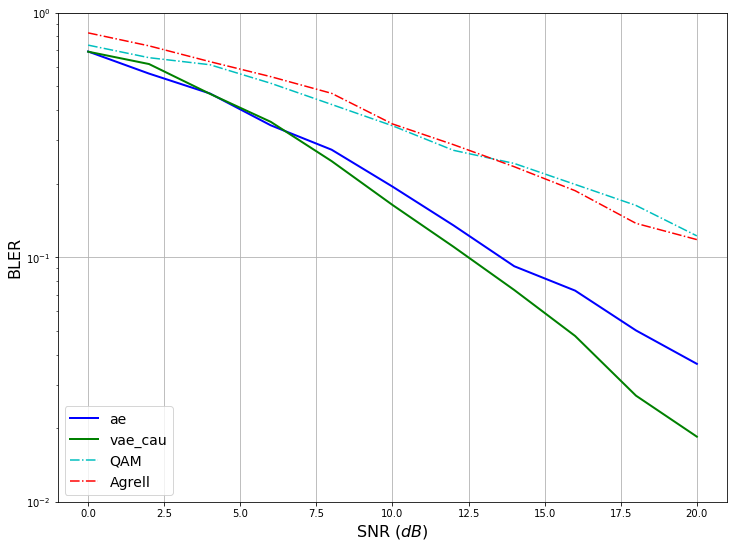

In [14]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(2*4*1.5,2*3*1.5))

for (label, result) in results.items():
    best_model_id = min(result, key=lambda l: result[l]['packing_density_en'][-1])
    plt.semilogy(result[best_model_id]["snr_dB"], 
                 result[best_model_id]["bler"], 
                 label=label, color=next(colors), linewidth=2,
                 linestyle=":" if "Oshea" in label or "[1]" in label else "-")

plt.semilogy(GSNR_range_dB, results_traditional["QAM"]["bler"], label="QAM", color=next(colors), linestyle="-.")
# plt.semilogy(SNR_range_dB, results_traditional["Agrell"]["bler"], label="Agrell [17]", color=next(colors), linestyle="-.")
plt.semilogy(GSNR_range_dB, results_traditional["Agrell"]["bler"], label="Agrell", color=next(colors), linestyle="-.")

plt.legend(loc="lower left", prop={'size':14})
plt.grid()
# plt.title("Best observed BLER of trained models", fontdict={'fontsize':18})
plt.xlabel("SNR ($dB$)", fontdict={'fontsize':16})
plt.ylabel("BLER", fontdict={'fontsize':16})
plt.ylim((1e-2,1e0))
robinhood(fig, "output_cau_best_bler_{:02d}x{:02d}.csv".format(blkSize,chDim), col_dtype=[int, float])

### Plot BLER with std dev

(0.01, 1.0)

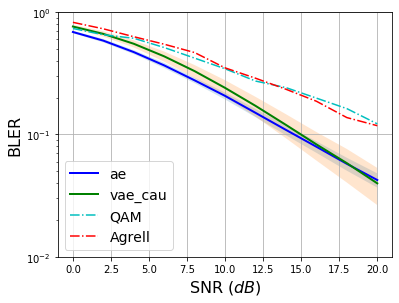

In [15]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(4*1.5,3*1.5))

for (label, result_dict) in results.items():
    clr = next(colors)
    
    d = [log["bler"] for (_, log) in result_dict.items()]
    d_mean = np.mean(d, axis=0)
    d_std = np.std(d, axis=0)
    
    plt.fill_between(result_dict[list(result_dict.keys())[0]]["snr_dB"],
                    d_mean + d_std, d_mean - d_std, alpha=0.20)
    plt.semilogy(result_dict[list(result_dict.keys())[0]]["snr_dB"],
                 d_mean, 
                 label=label, color=clr, linewidth=2,
                 linestyle=":" if "Oshea" in label or "[1]" in label else "-")
    
    # hack for robinhood to pickup shaded area
    plt.plot(result_dict[list(result_dict.keys())[0]]["snr_dB"],
             d_mean + d_std, color=clr, alpha=0.00, 
             label= label + "_upper" if enable_robinhood else None)
    plt.plot(result_dict[list(result_dict.keys())[0]]["snr_dB"],
             d_mean - d_std, color=clr, alpha=0.00, 
             label= label + "_lower" if enable_robinhood else None)
    
plt.semilogy(GSNR_range_dB, results_traditional["QAM"]["bler"], label="QAM", color=next(colors), linestyle="-.")
plt.semilogy(GSNR_range_dB, results_traditional["Agrell"]["bler"], label="Agrell", color=next(colors), linestyle="-.")
    
plt.legend(loc="lower left", prop={'size':14})
plt.grid()
plt.xlabel("SNR ($dB$)", fontdict={'fontsize':16})
plt.ylabel("BLER", fontdict={'fontsize':16})
plt.ylim((1e-2,1e0))
# plt.savefig("output_awgn_avg_bler_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
# robinhood(fig, "output_awgn_avg_bler_{:02d}x{:02d}.csv".format(blkSize,chDim), col_dtype=[int, float])

### Evolution of BLER @ 8dB

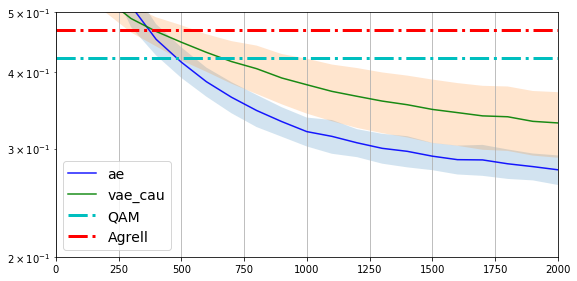

In [16]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(6*1.5, 3*1.5))
data = {}

for (label, result_dict) in results.items():
    epochs = result_dict[list(result_dict.keys())[0]]["bler_8dB_epochs"]
    d = []
    clr = next(colors)
    for (modelid, log) in result_dict.items():
#         plt.semilogy(log["packing_density_epochs"],
#                  log["packing_density_en"], color=clr, alpha=0.1)
        d.append(log["bler_8dB_bler"])
    d_mean = np.mean(d, axis=0)
    d_std = np.std(d, axis=0)
    plt.fill_between(result_dict[list(result_dict.keys())[0]]["bler_8dB_epochs"],
                    d_mean+d_std, d_mean-d_std, alpha=0.20)
    plt.semilogy(result_dict[list(result_dict.keys())[0]]["bler_8dB_epochs"],
                 d_mean, color=clr, alpha=0.9, label=label)
    
    # hack for robinhood to pickup shaded area
    plt.plot(result_dict[list(result_dict.keys())[0]]["bler_8dB_epochs"],
             d_mean + d_std,
             label= label + "_upper" if enable_robinhood else None,
             color=clr, alpha=0.00)
    plt.plot(result_dict[list(result_dict.keys())[0]]["bler_12dB_epochs"],
             d_mean - d_std,
             label= label + "_lower" if enable_robinhood else None,
             color=clr, alpha=0.00)
    
plt.plot(epochs, len(epochs)*[results_traditional["QAM"]["bler"][4]], linewidth=3, label="QAM", color=next(colors), linestyle="-.")
plt.plot(epochs, len(epochs)*[results_traditional["Agrell"]["bler"][4]], linewidth=3, label="Agrell", color=next(colors), linestyle="-.")


if blkSize==2 and chDim==1:
    plt.ylim([9e-2, 1.5e-1]) # For 02x01
elif blkSize==4 and chDim==2:
    plt.ylim([1.4e-1, 2.25e-1]) # For 04x02
elif blkSize==8 and chDim==4:
    plt.ylim([2e-1, 5e-1]) # For 08x04
plt.xlim([0, 2000])
plt.legend(loc='lower left', prop={'size':14})
plt.grid()
robinhood(fig, "output_cau_bler08dB_evo_{:02d}x{:02d}.csv".format(blkSize,chDim), col_dtype=[int, float])

### Evolution of BLER @ 12dB

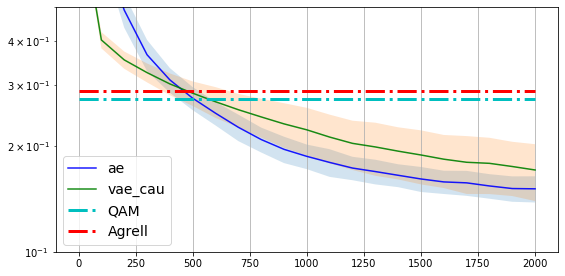

In [17]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
fig = plt.figure(figsize=(6*1.5, 3*1.5))
data = {}

for (label, result_dict) in results.items():
    epochs = result_dict[list(result_dict.keys())[0]]["bler_12dB_epochs"]
    d = []
    clr = next(colors)
    for (modelid, log) in result_dict.items():
#         plt.semilogy(log["packing_density_epochs"],
#                  log["packing_density_en"], color=clr, alpha=0.1)
        d.append(log["bler_12dB_bler"])
    d_mean = np.mean(d, axis=0)
    d_std = np.std(d, axis=0)
    plt.fill_between(result_dict[list(result_dict.keys())[0]]["bler_12dB_epochs"],
                    d_mean+d_std, d_mean-d_std, alpha=0.20)
    plt.semilogy(result_dict[list(result_dict.keys())[0]]["bler_12dB_epochs"],
                 d_mean, color=clr, alpha=0.9, label=label)
    
    # hack for robinhood to pickup shaded area
    plt.plot(result_dict[list(result_dict.keys())[0]]["bler_12dB_epochs"], d_mean + d_std,
             label= label + "_upper" if enable_robinhood else None,
             color=clr, alpha=0.00)
    plt.plot(result_dict[list(result_dict.keys())[0]]["bler_12dB_epochs"], d_mean - d_std, 
             label= label + "_lower" if enable_robinhood else None,
             color=clr, alpha=0.00)
    
plt.plot(epochs, len(epochs)*[results_traditional["QAM"]["bler"][6]], linewidth=3, label="QAM", color=next(colors), linestyle="-.")
plt.plot(epochs, len(epochs)*[results_traditional["Agrell"]["bler"][6]], linewidth=3, label="Agrell", color=next(colors), linestyle="-.")

if blkSize==2 and chDim==1:
    plt.ylim([4.5e-2, 9e-2]) # For 02x01
elif blkSize==4 and chDim==2:
    plt.ylim([6.0e-2, 2e-1]) # For 04x02
elif blkSize==8 and chDim==4:
    plt.ylim([1.0e-1, 0.5e0]) # For 08x04
# plt.xlim([0, 2000])
plt.legend(loc='lower left', prop={'size':14})
plt.grid()
robinhood(fig, "output_cau_bler12dB_evo_{:02d}x{:02d}.csv".format(blkSize,chDim), col_dtype=[int, float])